### (Version as of 2018-Nov-15)

Note: This document is written as a Jupyter notebook. If you would like to run the R code in this document, the corresponding ZIP file contains the Jupyter notebook file and the input data files required for running the code.

## Executive Summary

The HPI Simulator is a component of the RiskModel that simulates future home price paths for the U.S., state and CBSA markets. Mortgage defaults and prepayments are correlated with home price changes, so simulated HPI paths are used as inputs to the mortgage risk components of the RiskModel. (The HPI simulator model also simulates price paths for individual properties -- but that part of the model is not being revised.)

For each state or CBSA market, the HPI simulator is calibrated to generate simulated price paths that reflect that market's historical price path. The simulated paths should be more volatile in markets that have experienced more historical price volatility (i.e., bubble-prone markets) and should be less volatile for more stable markets. When multiple price paths are simulated for a single market, it is desirable for both the price levels (HPI) and price changes (HPA -- home price appreciation) to follow normal distributions, since many of the mortgage risk components in the RiskModel assume normal model errors. Furthermore, risk analysts are familiar with models that generate normally-distributed price paths.

The current production version of the HPI Simulator (4.4) generates non-normally distributed price paths that have other undesirable statistical properties:

1. The simulations bifurcate into two separate "high" and "low" distributions of HPI levels. This bifurcation becomes more pronounced when moving from initial to late simulation periods.
2. Price volatility decreases as simulated HPI paths move away farther away from the mean path specified in the RiskModel. Simulated price volatility should be independent of HPI levels.
3. The average volatilities of the simulated HPI paths do not match the values specified in the RiskModel.

The new HPI simulator (5.0) fixes these statistical problems:

1. The simulated price paths, both price levels (HPI) and price changes (HPA) follow non-bifurcated normal distributions.
2. Simulated price volatility is independent of the levels of the HPI paths.
3. The average volatilities of the simulated HPI paths closely match the values specified in the RiskModel.



## (1) Model Theory

### (1.1) Input Data and Parameter Overview

RiskModel users control the paths of the HPI simulations by either specifying a constant annualized rate of home price appreciation (HPA) or by providing mean paths of month-by-month HPA rates for each market. If a mean path is not provided for a market, the specified annual HPA rate generates a constant-slope mean path in log HPI levels. RiskModel users also specify annualized home price volatilities for each market to control the dispersion of simulated HPI paths.

The RiskModel calculates default values for the constant annualized HPA and volatilities based on the historical HPI for each market if users do not want to provide their own values. When these default values are used, the HPI simulations will follow paths that have average HPA rates and volatilities that match observed historical values. These default values are recalculated whenever updated HPI data is loaded into the RiskModel.

The HPI simulator also accounts for HPA correlations across different markets. For simulation purposes, these cross-market correlations are stored in static Cholesky decompositions of historical HPA correlation matrices -- one for the U.S. and states and another for metro areas. These Cholesky decomposition matrices were tabulated as part of the HPI Simulator 5.0 calibration process and are not updated inside of the RiskModel.

Finally, three model simulation parameters control the HPI simulation paths for each market given the mean HPA paths (or constant annualized HPA rates) and annualized price volatilities specified by a RiskModel user (or their default values). The first two model parameters, which measure rates of HPA momentum and mean reversion, were estimated in the HPI Simulator 5.0 calibration process and are not updated inside of the RiskModel. The third parameter is the residual volatility in each market after removing momentum and mean reversion price volatility. The residual volatility parameters are updated inside of the RiskModel to reflect the user-specified (or default) annualized volatilities for each market.

The following table lists the HPI simulator model variables.

| Variable             | R Code             | Description                                      |
| :------------------- | :------------------ | :---------------------------------------------- |
| $ i $                | i                   | Market                                         |
| $ t $                | j                   | Simulation month                               |
| $ k $                | k                   | Simulation path                                |
| ${}$                   | num.markets         | Number of markets                              |
| ${}$                | num.months          | Number of simulation months                    |
| ${}$                     | num.sims            | Number of simulation paths                     |
| ${}$                     |  ${}$                   | ${}$                                                |
| $ LnHPI_i $          | hpi\$ln.hpi         | Log HPI                                        |
| $ AdjLnHPI_i $       | hpi\$adj.ln.hpi     | Log HPI, seasonally-adjusted                   |
| $ SeasFac_i $        | hpi\$seas.fac       | Seasonal adjustment factors                    |
| ${}$                 | ${}$                | ${}$                                           |
| $ AvgHPA_i $         | hist.values\$avg.hpa | Average annual HPA, historical                 |
| $ AvgVol_i $         | hist.values\$avg.vol | Average annual HPA volatility, historical     |
| ${}$                 | ${}$                 | ${}$                                          |
| $ Dev \Delta AdjLnHPI^k_i $ | ch   | Deviation of HPA from mean HPA path           |
| $ \overline{\Delta AdjLnHPI}_i $ | mean.hpa.path | Mean HPA path                    |
| $ \overline{AdjLnHPI}_i $      | mean.hpi.path   | Mean HPI path                    |
| $ z^k_{i,t} $                     | z | Standard normal disturbances                    |
| ${}$ | ${}$ | ${}$ |
| $ \hat{\alpha}_i $ | sim.mod.coefs\$reversion | Estimated mean reversion parameter |
| $ \hat{\beta}_i $ | sim.mod.coefs\$momentum | Estimate momentum parameter |
| $ \hat{\sigma}_i \sqrt{12} $ | hist.values\$resid.vol | Residual volatility parameter, annualized |
| ${}$ | ${}$ | ${}$ |
| $ C_{ij} $ | chol.mat | Cholesky decomposition of HPA correlation matrix |
| ${}$ | ${}$ | ${}$ |
| ${}$ | hpi.array | Simulated HPI paths

### (1.2) Updating the Default Annualized HPA and Volatility Parameters

Historical HPI values are used to calculate the default annualized HPA and volatility parameters. However, before these values are calculated, the HPI must be seasonally-adjusted to remove the effects of seasonal home price fluctuations on these parameter estimates.

The seasonally-adjusted HPI estimates are calculated by applying a series of centered, non-truncated moving average filters to the HPI values.

$$\large ma_{t}(x, n) = \left(\sum_{max(t_0, t-s)}^{min(t+s, T)} x_{t} \right) \big/ \left( min(t+s, T) - max(t_0, t-s) + 1 \right)$$

where $x$ is an unfiltered series, $n$ is the (odd) moving average sample size, $s = (n-1)/2$, and $t_0$ and $T$ are the start and end periods of the unfiltered series.

In [3]:
# R function for centered moving average

ma <- function(x, n) {
   
    t0 <- 1
    T <- length(x)
    x.ma <- rep(as.numeric(NA), T)
    s <- (n-1)/2
    
    for (t in t0:T) {
        lower.index <- max(t0, t-s)
        upper.index <- min(t+s, T)
        x.ma[t] <- sum(x[lower.index:upper.index])/(upper.index-lower.index+1)
    }
    
    return(x.ma)
}

The first step in the seasonal adjustment procedure is to transform the HPI to natural logs: $LnHPI_i = ln(HPI_i)$ for market $i$. Then calculate a 25-month, centered moving average of the log HPI values: $ma(LnHPI_i, 25)$. The differences between the unadjusted log HPI values and the 25-month moving average are the seasonal fluctuations in the log HPI values.

The next step is to apply two moving average filters (1st: $n=5$, 2nd: $n=3$) sequentially to the seasonal fluctuations. These calculations, however, are done separately for each calendar month. The moving averages from the last filter are 'seasonal factors' ($ SeasFac_i $) -- the average seasonal fluctuations for particular calendar months averaged over multiple years.

The seasonally-adjusted log HPI series is equal to the differences between the unadjusted series and the seasonal factors: 

$$AdjLnHPI_i = LnHPI_i - SeasFac_i$$

In [4]:
# Load state-level HPI from a bulk export file

library(sqldf)
library(stringr)

hpi.state <- read.csv.sql('HPI_Bulk_Export_by_STATE_201903.csv',
                          sql = 'select STATE_CODE as state, 
                                        substr(YYYYMM,5,2) as mm,
                                        YYYYMM as yyyymm, 
                                        HOME_PRICE_INDEX as hpi
                                   from file
                                  where TIER_CODE = 11
                                  order by STATE_CODE, YYYYMM')
if (!is.null(getOption("sqldf.connection"))) sqldf()

# Pad state FIPS codes with leading zeros
hpi.state$state <- str_pad(as.character(hpi.state$state), 2, 
                           side=c("left"), "0")

# Log transform HPI (in R, log = natural log)
hpi.state$ln.hpi <- log(hpi.state$hpi)

# Create list of states
states <- as.list(unique(hpi.state$state))

# Add columns for storing seasonal adjustment results
hpi.state[,c('seas.fluc','seas.fac','adj.ln.hpi')] <- as.numeric(NA)

# Loop over states
for (i in states) {
    
    # Extract rows for state
    hpi <- hpi.state[hpi.state$state==i,]

    # Create list of month labels
    mths <- as.list(unique(hpi$mm))

    # Calculate seasonal fluctuations
    ma25.ln.hpi <- ma(hpi$ln.hpi, 25)
    hpi$seas.fluc <- hpi$ln.hpi - ma25.ln.hpi

    # Calculate seasonal factors
    # Loop over calendar months
    for (m in mths) {
    
        # Extract hpi dataframe rows for given calendar month
        hpi.mth <- hpi[hpi$mm==m,]
    
        # 5-period (5-year) moving average
        ma5.seas.fluc <- ma(hpi.mth$seas.fluc, 5)
    
        # 3-period (3-year) moving average of 5-period (5-year) moving average
        ma3.ma5.seas.fluc <- ma(ma5.seas.fluc, 3)
    
        # Put seasonal factors into hpi dataframe
        hpi$seas.fac[hpi$mm==m] <- ma3.ma5.seas.fluc

    }

    # Calculate seasonally-adjusted log HPI
    hpi$adj.ln.hpi <- hpi$ln.hpi - hpi$seas.fac
 
    # Put results into hpi.state
    hpi.state$seas.fluc[hpi.state$state==i] <- hpi$seas.fluc
    hpi.state$seas.fac[hpi.state$state==i] <- hpi$seas.fac
    hpi.state$adj.ln.hpi[hpi.state$state==i] <- hpi$adj.ln.hpi
    
}

# Look at results for U.S.
head(hpi.state[hpi.state=='00',], n=24)

state,mm,yyyymm,hpi,ln.hpi,seas.fluc,seas.fac,adj.ln.hpi
00,01,197601,24.3355,3.191936,0.006565101,-0.005537242,3.197473
00,02,197602,23.3807,3.151911,-0.038348718,-0.015963486,3.167874
00,03,197603,23.1023,3.139932,-0.055921241,-0.017095410,3.157028
00,04,197604,22.9976,3.135390,-0.066376669,-0.018401045,3.153791
00,05,197605,23.2123,3.144682,-0.063128402,-0.016284570,3.160967
00,06,197606,23.9770,3.177095,-0.037326426,-0.004965256,3.182060
00,07,197607,24.1324,3.183555,-0.037339520,-0.004507219,3.188063
00,08,197608,24.3454,3.192343,-0.034984324,-0.003737719,3.196081
00,09,197609,24.4485,3.196569,-0.036845175,-0.007017374,3.203586
00,10,197610,24.7801,3.210041,-0.029278527,-0.007233309,3.217274


The average annual HPA parameter value is calculated by converting the cumulative return for the entire seasonally-adjusted log HPI series to an annual frequency:

$$AvgHPA_i = \left( AdjLnHPI_{i, T} - AdjLnHPI_{i, t_0} \right) \times \left( 12 / (T - 1) \right)  $$

The average annual price volatility parameter value is equal to the standard deviation of the 1st differences in the seasonally-adjusted log HPI series converted to an annual frequency:

$$AvgVol_i = StdDev \left ( \Delta AdjLnHPI_i \right ) \times \sqrt {12}$$

In [5]:
t0 <- 1
T <- nrow(hpi)

# Calculate average annual HPA and volatility for a subset of states
states <- list("00",   # National
               "01",
               "04",   # Arizona
               "06")   # California

# Data frame for storing results
hist.values <- data.frame(avg.hpa=rep(as.numeric(NA),length(states)),
                          avg.vol=rep(as.numeric(NA),length(states)))
rownames(hist.values) <- unlist(states)

for (i in states) {

    cat(paste("State:",i,"\n"))
    
    # Extract rows for state
    hpi <- hpi.state[hpi.state$state==i,]
    
    # Average annual HPA
    avg.hpa <- (hpi$adj.ln.hpi[T] - hpi$adj.ln.hpi[t0])*(12/(T-1))
    cat(paste("Average Annual HPA:",avg.hpa,"\n"))

    # Average annual volatility
    avg.vol <- sd(diff(hpi$adj.ln.hpi, lag=1))*sqrt(12)
    cat(paste("Average Annual Volatility:",avg.vol,"\n"))
    
    # Store results
    hist.values[i,'avg.hpa'] = avg.hpa
    hist.values[i,'avg.vol'] = avg.vol
    
    cat("\n")
    
}

hist.values

State: 00 
Average Annual HPA: 0.0492984534475929 
Average Annual Volatility: 0.0207230773291785 

State: 01 
Average Annual HPA: 0.0333775575464963 
Average Annual Volatility: 0.0207930546907421 

State: 04 
Average Annual HPA: 0.0444788533483569 
Average Annual Volatility: 0.0292424775765046 

State: 06 
Average Annual HPA: 0.0628138812367493 
Average Annual Volatility: 0.0306958497342289 



,avg.hpa,avg.vol
00,0.04929845,0.02072308
01,0.03337756,0.02079305
04,0.04447885,0.02924248
06,0.06281388,0.03069585


### (1.3) Calculating the Value of the Residual Volatility Parameter

For the HPI Simulator 5.0, the price volatility for each market is assumed to be the sum of the volatility that can be predicted by the simulation model and the remaining unpredictable, residual volatility. The 5.0 simulation model is defined as:

$$ Dev \Delta AdjLnHPI^k_{i, t} = \alpha_i \cdot (AdjLnHPI^k_{i, t-1} - \overline{AdjLnHPI}_{i, t-1}) $$

$$ + \beta_i (Dev \Delta AdjLnHPI^k_{i, t-1}) + \sum_{j \neq i} C_{ij}\sigma_j z^k_{j, t} + \sigma_i z^k_{i, t} $$

where

$ Dev \Delta AdjLnHPI^k_{i, t} = ( \Delta AdjLnHPI^k_{i, t} - \overline {\Delta AdjLnHPI}_{i, t} ) $ is the home price change deviation from the mean HPA path for period $t$, market $i$, and simulation path $k$,

$ \overline{AdjLnHPI}_{i} $ is the mean log HPI path,

$ \alpha_i $ is a mean reversion coefficient for market $i$,

$ \beta_i $ is a momentum coefficient for market $i$,

$ C_{ij} $ is the Cholesky decomposition of the cross-market correlations of $ Dev \Delta AdjLnHPI_{i} $, 

$ \sigma_i $ is the monthly residual volatility of $ Dev \Delta AdjLnHPI_{i} $ for market $i$, and

$ z^k_{i, t} $ is a standard normal disturbance.


There are two sources of within-market volatility in the simulation model: (1) the volatility that is predicted by the mean reversion and momentum terms and (2) the unpredictable residual volatility, which is represented by the $ \sigma_i $ coefficient. (We ignore the cross-market correlations of $ Dev \Delta AdjLnHPI_{i} $ when estimating the residual volatilities.)

The simulation model is essentially an AR(1) time series model, where $ \beta_i $ is the auto-correlation coefficient for $ Dev \Delta AdjLnHPI_{i} $. (The estimated mean reversion coefficients, $ \hat{\alpha}_i $, are very small compared to the estimated $ \hat{\beta}_i $ coefficients, so it is O.K. to ignore them when calculating the residual volatilities of the simulation model.) For the AR(1) formulation of the simulation model, the estimated residual variance is defined as:

$$ \hat{\sigma}^2_i = Var(Dev \Delta AdjLnHPI_{i}) \cdot (1 - \hat{\beta}^2_i ) $$

When calculating the historical HPA and volatility parameters, it is assumed that HPA is constant over time (i.e., $ \overline{\Delta AdjLnHPI}_{i, t} $ is a constant), so

$$ \hat{\sigma}^2_i = Var(\Delta AdjLnHPI_{i}) \cdot (1 - \hat{\beta}^2_i ) $$

The residual volatility is equal to the square root of the residual variance.

Regression estimates of AR(1) coefficients are biased, however, so the estimates of $ \hat{\sigma}_i $ will also be biased. To remove this bias, correction factors were calculated based on the observed annual HPA volatilities of the state- and CBSA-level HPI. For markets where $ \hat{\beta}_i > 0.6 $ the bias-corrected residual volatility is equal to:

$$ \hat{\sigma}_i = \sqrt{\hat{\sigma}^2_i} + exp(-11.9198 + 4.8306 \hat{\beta_i}) \big{/} \sqrt{12} $$

For markets where $ \hat{\beta}_i \leq 0.6 $ the bias-corrected residual volatility is equal to:

$$ \hat{\sigma}_i = \sqrt{\hat{\sigma}^2_i} + exp(-10.83362 + 3.95718 \hat{\beta_i}) \big{/} \sqrt{12} $$

For a few CBSA-level markets, insufficient HPI data prevents the estimation of reliable simulation model coefficients. For these markets, the values of $ \hat{\alpha}_i $ and $ \hat{\beta}_i $ are set equal to zero and the residual volatility is set equal to the standard deviation of the historical HPA.

$$ \hat{\sigma}_i = StdDev(\Delta AdjLnHPI_{i}) $$

In [6]:
# Calculate residual volatility for a subset of states
states <- list("00",   # National
               "01",
               "04",   # Arizona
               "06")   # California

# Load state-level simulation model coefficients
sim.mod.coef <- read.csv("lm.mod.coef.states.csv", 
                        colClasses=c("character","character",
                                     "numeric","numeric"), row.names=c(1))
sim.mod.coef <- sim.mod.coef[unlist(states),]

# Add coloumn to hist.values
hist.values[,'resid.vol'] <- as.numeric(NA)

for (i in states) {

    # Convert annual volatility to monthly
    mth.vol <- hist.values[i,"avg.vol"]/sqrt(12)

    momentum <- sim.mod.coef[i,'momentum']
    
    # Calculate residual volatility estimates
    if (momentum!=0.0) {
    
        if (momentum>0.6) {
        
            resid.var <- (mth.vol^2) * (1 - (momentum)^2)
            resid.vol = sqrt(resid.var) + 
                            exp(-13.491 + 4.802*momentum)/sqrt(12)
        
        } else {
        
            resid.var <- (mth.vol^2) * (1 - (momentum)^2)
            resid.vol = sqrt(resid.var) + 
                            exp(-12.1250 + 1.7046*momentum)/sqrt(12)
        
        }

    } else {
    
        resid.vol = mth.vol
    
    }
    
    cat(paste("State:",i,"\n"))

    # Average annual volatility
    cat(paste("Average Annual Volatility:",hist.values[i,"avg.vol"],"\n"))

    # Average annual residual volatility
    cat(paste("Average Annual Residual Volatility:",resid.vol*sqrt(12),"\n"))
    
    # Store results
    hist.values[i,'resid.vol'] <- resid.vol*sqrt(12)
    
    cat("\n")
    
}

hist.values

State: 00 
Average Annual Volatility: 0.0207230773291785 
Average Annual Residual Volatility: 0.0105720782783567 

State: 01 
Average Annual Volatility: 0.0207930546907421 
Average Annual Residual Volatility: 0.0201358848644831 

State: 04 
Average Annual Volatility: 0.0292424775765046 
Average Annual Residual Volatility: 0.0104772463562713 

State: 06 
Average Annual Volatility: 0.0306958497342289 
Average Annual Residual Volatility: 0.0133943543432253 



,avg.hpa,avg.vol,resid.vol
00,0.04929845,0.02072308,0.01057208
01,0.03337756,0.02079305,0.02013588
04,0.04447885,0.02924248,0.01047725
06,0.06281388,0.03069585,0.01339435


## (2) Model Performance

### (2.1) Simulating HPI Paths (Default Parameter Values)

Individual HPA paths are simulated by applying the simulation model formula on a month-by-month basis to recursively generate values of $Dev \Delta AdjLnHPI^k_{i, t}$ . For the initial simulation period, $ (AdjLnHPI^k_{i, t-1} - \overline{AdjLnHPI}_{i, t-1}) $ is set equal to zero and then is updated as each simulated HPI path drifts above or below the mean HPI path.

The HPI path is updated using the following formula:

$$ AdjLnHPI^k_{i, t} = AdjLnHPI^k_{i, t-1} + Dev \Delta AdjLnHPI^k_{i, t} + \overline{\Delta AdjLnHPI}_{i, t} $$

In [7]:
simulate.mod.multi.chol <- function(num.months, mean.hpa.path, 
                                    initial.hpi, mean.hpi.path, 
                                    mod.coef, chol.mat) {
  
  # mean.hpa.path is the mean HPA path
  # mean.hpi.path is the mean HPI path
    
  # mod.coef are the simulation model coefficients
  # chol.mat is the Cholesky decomposition of the 
  #      cross-market HPA correlation matrix
    
  # num.months is the number of simulation periods
  # num.markets is the number of markets in the simulation
  num.markets <- nrow(initial.hpi)
  
  # Create matrix for storing simulation results
  hpi <- matrix(NA, nrow=num.markets, ncol=num.months)
  rownames(hpi) <- rownames(initial.hpi)
  
  # Matrix of standard normal disturbances
  z <- matrix(rnorm(num.markets*num.months, 0, 1),
              nrow=num.months, ncol=num.markets)
  
  # Multiply by Cholesky matrix to get correlated disturbances
  # %*% is the R matrix multiplication operator
  z <- z %*% chol.mat
  
  # Multiply (element-by-element) by residual volatilities
  # (Rescale each market's correlated disturbances by sigma)
  # t is the R transpose operator
  innov <- t(t(z) * mod.coef$sigma)
    
  # Loop across markets
  for (i in 1:num.markets) {
    
    market <- rownames(initial.hpi)[i]
    
    ch <- rep(NA, num.months)
    ch[1] <- 0
    
    hpi[market,1] <- log(initial.hpi[market,])
    
    diff.trend <- 0
    
    # Loop across simulation months  
    for (t in 2:num.months) {
      
      # Simulate HPA deviation  
      ch[t] <- mod.coef[market,"momentum"]*ch[t-1] +
        mod.coef[market,"reversion"]*diff.trend +
        innov[t,i]
      
      # Update simulated HPI level  
      hpi[market,t] <- hpi[market,t-1] + ch[t] + mean.hpa.path[market,t]
        
      # Update HPI difference from mean HPI path  
      diff.trend <- hpi[market,t] - mean.hpi.path[market,t]
    
    }
    
  }
  
  return(hpi)
    
}


Before a simulation can be run, both the mean HPA $(\overline{\Delta AdjLnHPI}_{i, t})$ and mean HPI paths $(\overline{AdjLnHPI}_{i, t})$  must be specified. If historical default HPA and HPI paths are being used, then the first step is to generate a vector of constant month-by-month HPA rates for each market and for all simulation months, where each vector element is set equal to the historical monthly HPA rate.

The initial HPI values must also be set for each market. (In this example, they are set equal to 1.0). Finally, the period-by-period mean HPI paths are calculated by adding the cumulative sums of the mean HPA vectors to the initial HPI values.

In [8]:
# Load some helper functions for displaying results
source("(0)_Functions_Jupyter_Notebook.R")

# Run HPI simulation for a subset of states
states <- c("00",   # National
            "01",
            "04",   # Arizona
            "06")   # California

num.markets <- 4    # Number of markets being simulated
num.months <- 360   # 30-year simulation horizon
num.sims <- 10000   # Number of simulation paths

# Extract HPI for subset of states
hpi <- hpi.state[hpi.state$state %in% states,]

# Set constant mean HPA rates to historical (monthly) averages
mean.hpa <- matrix(hist.values$avg.hpa/12, nrow=num.markets, ncol=1)
rownames(mean.hpa) <- states

# Convert mean HPA rate to mean HPA paths
mean.hpa.path <- t(tcrossprod(rep(1,num.months), mean.hpa))
rownames(mean.hpa.path) <- states

# Set initial HPI values for simulation
initial.hpi <- matrix(1.0, nrow=num.markets, ncol=1)
rownames(initial.hpi) <- states

# Generate mean HPI paths by applying mean HPA paths to initial HPI values
mean.hpi.path <- matrix(NA, nrow=num.markets, ncol=num.months)
rownames(mean.hpi.path) <- states
for (i in 1:length(states)) {
  mean.hpi.path[i,] <- exp(c(log(initial.hpi[i,1]), 
                             log(initial.hpi[i,1])+
                             cumsum(mean.hpa.path[i,2:num.months])))
}
dimnames(mean.hpi.path) <- list(market=rownames(initial.hpi),
                                 period=c(1:dim(mean.hpi.path)[2]))

If a default historical HPA rate is used, then the HPA rate is constant from month to month and the log mean HPI path will have a constant slope.

Warning message:
"package 'ggplot2' was built under R version 3.5.3"

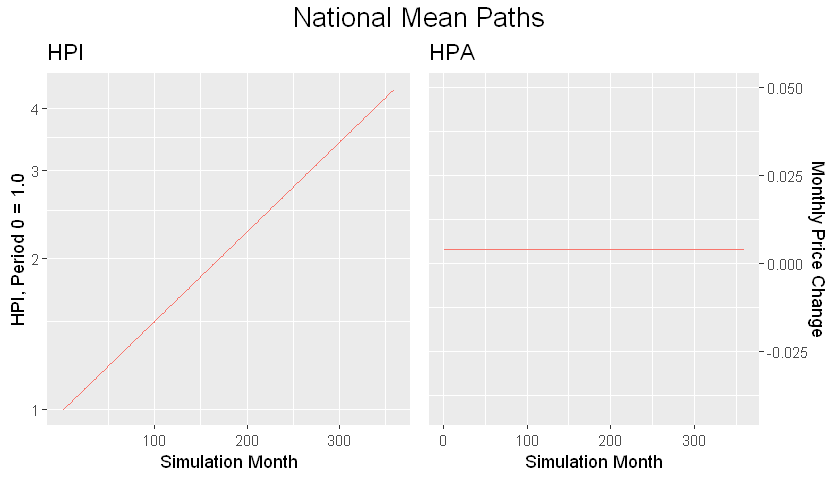

In [9]:
library(ggplot2)
library(grid)
library(gridExtra)

# Plot national mean HPA and HPI paths
state <- "00"

path.df <- data.frame(period=1:num.months,
                      mean.hpa.path=mean.hpa.path[state,],
                      mean.hpi.path=mean.hpi.path[state,])

options(repr.plot.height=4)
plot1 <- ggplot(path.df, aes(x = period)) +
            geom_line(aes(y=mean.hpi.path, colour="Mean HPI Path")) +
            ggtitle("HPI") +
            coord_trans(y = "log") +
            xlab("Simulation Month") +
            ylab("HPI, Period 0 = 1.0") +
            theme(legend.position="none")
plot2 <- ggplot(path.df, aes(x = period)) +
            geom_line(aes(y=mean.hpa.path, colour="Mean HPA Path")) +
            ggtitle("HPA") +
            scale_y_continuous(position = "right") +
            xlab("Simulation Month") +
            ylab("Monthly Price Change") +
            theme(legend.position="none")
grid.arrange(plot1, plot2, ncol=2, 
             top = textGrob("National Mean Paths",gp=gpar(fontsize=16)))


In addition to mean HPA and HPI vectors, the simulation function also requires the estimated mean reversion $(\hat{\alpha}_i)$ and momentum $(\hat{\beta}_i)$ parameters for each market and the Cholesky decomposition $(C_{ij})$ of the HPA correlation matrix across all markets.

The residual volatility parameter $(\hat{\sigma}_i)$ is set equal to the historical residual volatility converted to a monthly frequency. RiskModel users can also set the own annual price volatility values to increase or decrease the dispersion in the simulated HPI paths. The residual volatility calculation code (see above) will remove the predicted volatility from the user-specified values to provide estimates of each market's annual residual volatility.

The simulation model is defined in terms of log HPI, so log-transformed values of the mean HPI path must be passed to the simulation function.

In [10]:
library(reshape2)

# Create array for storing HPI simulation results
    # Dimension 1: states
    # Dimension 2: simulation
    # Dimension 3: month
hpi.array <- array(NA, dim=c(nrow(initial.hpi), num.sims, num.months))
dimnames(hpi.array) <- list(market=rownames(initial.hpi),
                            sim=c(1:dim(hpi.array)[2]),
                            period=c(1:dim(hpi.array)[3]))

# Load HPA correlation matrix (only used for printing correlation targets)
cor.mat <- read.csv("cor.state.csv", header=TRUE, row.names=1)

state.codes <- str_pad(rownames(cor.mat), 2, side=c("left"), "0")
cor.mat <- as.matrix(cor.mat)
rownames(cor.mat) <- state.codes
colnames(cor.mat) <- state.codes
cor.mat <- cor.mat[states, states]   # Keep rows and columns for target states

# Load HPA correlation Cholesky decomposition matrix (used in simulation)
chol.mat <- read.csv("chol.state.csv", header=TRUE, row.names=1)

state.codes <- str_pad(rownames(chol.mat), 2, side=c("left"), "0")
chol.mat <- as.matrix(chol.mat)
rownames(chol.mat) <- state.codes
colnames(chol.mat) <- state.codes
chol.mat <- chol.mat[states, states] # Keep rows and columns for target states

# Load state-level simulation model coefficients
sim.mod.coef <- read.csv("lm.mod.coef.states.csv", 
                        colClasses=c("character","character",
                                     "numeric","numeric"), row.names=c(1))
sim.mod.coef <- sim.mod.coef[unlist(states),]

# Add sigma coefficients to model coefficients
#   Sigma = monthly residual volatlity
sim.mod.coef$sigma <- hist.values$resid.vol/sqrt(12)

# Run simulations
for (k in 1:num.sims) {
  
  hpi.array[,k,] <- exp(simulate.mod.multi.chol(num.months, mean.hpa.path, 
                                                initial.hpi, log(mean.hpi.path), 
                                                sim.mod.coef, chol.mat))
  
}

r_multi <- summ.by.sim(hpi.array)


cat("\n")
cat("Annual Mean Returns:\n")
ret.mean <- aggregate((ret.mean*12)~market, data=r_multi, mean)
ret.mean[,2] <- format(ret.mean[,2], digits=5)
ret.mean[,3] <- format(mean.hpa*12, digits=5)
colnames(ret.mean) <- c('state','ret.mean','target')
ret.mean$state <- states
print(ret.mean, row.names=FALSE)

cat("\n")
cat("Annual Return Standard Deviations:\n")
sd.mean <- aggregate((ret.sd*sqrt(12))~market, data=r_multi, mean)
sd.mean[,2] <- format(sd.mean[,2], digits=5)
sd.mean[,3] <- format(hist.values$avg.vol[order(rownames(hist.values))], 
                      digits=5)
colnames(sd.mean) <- c('state','sd.mean','target')
sd.mean$state <- states
print(sd.mean, row.names=FALSE)

cat("\n")
cat("Target Residual Correlations:\n")
rho.df <- data.frame(cor.mat,
                     row.names=rownames(cor.mat))
colnames(rho.df) <- colnames(cor.mat)
print(format(rho.df, digits=3))

cat("\n")
cat("Simulated Residual Correlations:\n")
cor.mat <- hpa_dev.cor(hpi.array, mean.hpa)
print(format(cor.mat, digits=3))



Annual Mean Returns:
 state ret.mean   target
    00 0.049232 0.049298
    01 0.033405 0.033378
    04 0.044456 0.044479
    06 0.062885 0.062814

Annual Return Standard Deviations:
 state  sd.mean   target
    00 0.020607 0.020723
    01 0.020765 0.020793
    04 0.028330 0.029242
    06 0.027747 0.030696

Target Residual Correlations:
       00     01     04    06
00 1.0000 0.0676 0.0992 0.128
01 0.0676 1.0000 0.1034 0.192
04 0.0992 0.1034 1.0000 0.256
06 0.1285 0.1918 0.2555 1.000

Simulated Residual Correlations:
       00     01     04    06
00 1.0000 0.0677 0.0983 0.139
01 0.0677 1.0000 0.1078 0.214
04 0.0983 0.1078 1.0000 0.235
06 0.1392 0.2138 0.2351 1.000


The simulated HPI paths will follow cyclical patterns above and below the specified mean HPI path. The magnitudes and frequency of these HPI cycles will depend on the estimated values of the mean reversion, momentum, and residual volatility parameters.

Because the simulation model is defined for deviations in price changes around the mean HPA path, a market's average simulated HPI path will track closely with its specified mean HPI path. But the *simulated paths are not constrained to the mean HPI path*, so there will be some small differences between the average of the simulated HPI paths and the target mean HPI path. As the number of simulations is increased and the means of the random disturbances approach zero, the differences between the average of the simulated paths and the target mean path will also approach zero.

In the example shown above, separate sets of 2,000 HPI paths are simulated for the U.S., Arizona and California. The average simulated HPA rates ("ret.mean") are almost exactly equal to their specified targets ("target"). The average simulated price volatilities ("sd.mean") are close to their targets, but there are some small differences. Partly this is because price volatilities require larger simulation samples than price levels before their asymptotic distributions settle upon their exact target distributions. But some portion of these discrepancies result from the remaining biases in the estimated bias-corrected residual volatility parameter estimates. These uncorrectable biases will be larger in markets with larger momentum parameters ($ \hat{\beta}_i $). The U.S., Arizona, and California are all high momentum markets -- historically, they have experienced very large home price cycles -- so the discrepancies between their average simulated and target price volatilities will be larger than for most markets.

The cross-market HPA correlations of the simulated price paths are also close to their targets. Since the pairwise asymptotic properties of the correlation distributions depend on the asymptotic properties of *two* price volatility distributions, the simulated correlations will converge even more slowly to their targets than the simulated price volatilities.

The graph displayed below shows results for the simulated U.S. HPI paths. The average of the simulated HPI paths (the thick black line) is nearly identical to the historically-derived constant-slope mean HPI path. (Note: Only the first 20 simulated HPI paths are displayed as colored lines on the chart.) Although it is not immediately apparent in the graph, for all simulation periods both the HPI levels and changes (HPA) follow normal distributions. The price volatilities are also independent of the levels of the simulated HPI. This can be seen in the graph -- the changes in the simulated price paths (month-to-month zig-zags in each colored line) do not become larger or smaller as each path moves closer to or farther away from the mean HPI path (the thick black line).

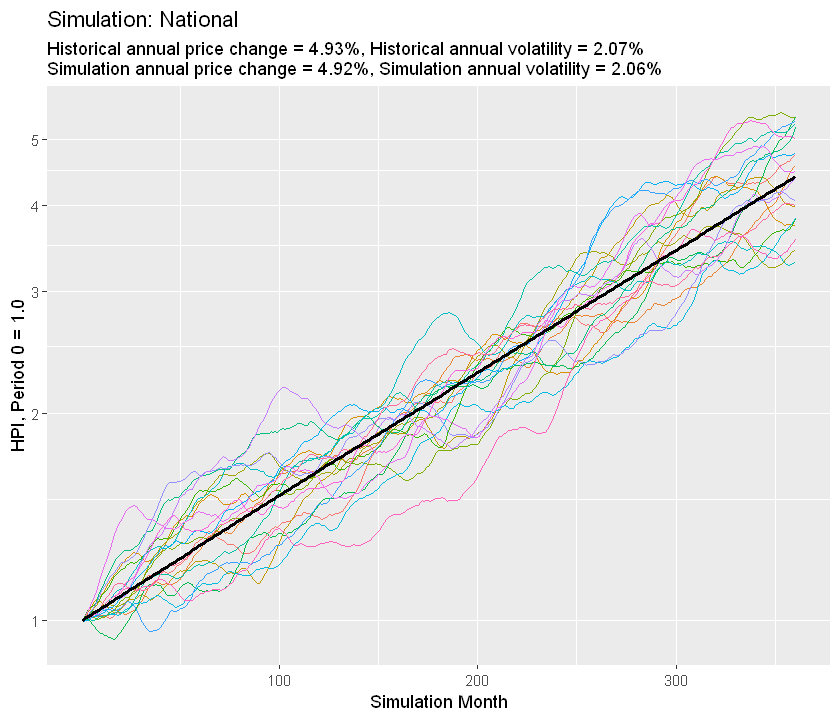

In [11]:
library(scales)

state <- "00"

hpi.array.us <- hpi.array[state,,]

hpi.paths <- as.data.frame(as.table(hpi.array.us))
hpi.paths$period <- as.integer(hpi.paths$period)
colnames(hpi.paths)[3] <- "value"

options(repr.plot.height=6)
print(ggplot(hpi.paths, aes(period, value)) + 
        geom_line(aes(colour = sim), 
                  data=function(x){x[x$sim %in% as.character(1:20), ]}) +
        stat_summary(aes(y = value), fun.y=mean, colour="black", 
                     geom="line", size=1) +
        coord_trans(y = "log") +
        theme(legend.position="none") +
        ggtitle(paste("Simulation: National"),
                subtitle=(paste0("Historical annual price change = ",
                                 percent(as.numeric(mean.hpa[state,])*12),
                                 ", Historical annual volatility = ",
                                 percent(hist.values[state,'avg.vol']),
                                 "\n",
                                 "Simulation annual price change = ",
                                 percent(as.numeric(ret.mean[ret.mean$state==state,"ret.mean"])), 
                                 ", Simulation annual volatility = ",
                                 percent(as.numeric(sd.mean[sd.mean$state==state,"sd.mean"]))))) +
        xlab("Simulation Month") +
        ylab("HPI, Period 0 = 1.0"))

### (2.2) Simulating HPI Paths (User-Specified Mean HPA Paths)

Because the simulation model is defined in terms of deviations from the mean HPA path, it is easy to generate simulations that follow any specified HPA path (and its corresponding HPI path). In the following example, the constant HPA paths for the U.S., Arizona and California are replaced by paths where HPA is equal to its historical rate for the first 15 years of the simulation, but immediately drops to zero in years 16 through 30.

As with the constant HPA simulation, the average HPI path for the partially flat-lined HPA simulation tracks closely with the specified mean HPI path. The average simulated HPA rates ("ret.mean") are nearly identical to their targets ("target"). The simulated price volatilities ("sd.mean") are close to their targets, but do not match exactly due to the uncorrectable bias in the simulation model's estimate residual volatility parameters and the slower asymptotic convergence of the mean volatilities. As in the previous example, the HPA correlations are the farthest from their targets, but the general historical patterns of the correlations between U.S., Arizona and California markets are maintained.

In [12]:
# Run HPI simulation for a subset of states
states <- c("00",   # National
            "01",
            "04",   # Arizona
            "06")   # California

num.markets <- 4    # Number of markets being simulated
num.months <- 360   # 30-year simulation horizon
num.sims <- 2000    # Number of simulation paths

# Extract HPI for subset of state
hpi <- hpi.state[hpi.state$state %in% states,]

# Set constant mean HPA rates to historical (monthly) averages
# But flatline HPA for last 15 years of simulation
mean.hpa <- matrix(hist.values$avg.hpa/12, nrow=num.markets, ncol=1)
rownames(mean.hpa) <- states

# Convert mean HPA rate to mean HPA paths
mean.hpa.path <- t(tcrossprod(rep(1,num.months), mean.hpa))
mean.hpa.path[,181:360] <- rep(0, num.markets)
rownames(mean.hpa.path) <- states

# Set initial HPI values for simulation
initial.hpi <- matrix(1.0, nrow=num.markets, ncol=1)
rownames(initial.hpi) <- states

# Generate mean HPI paths by applying mean HPA paths to initial HPI values
mean.hpi.path <- matrix(NA, nrow=num.markets, ncol=num.months)
rownames(mean.hpi.path) <- states
for (i in 1:length(states)) {
  mean.hpi.path[i,] <- exp(c(log(initial.hpi[i,1]), 
                             log(initial.hpi[i,1])+
                             cumsum(mean.hpa.path[i,2:num.months])))
}
dimnames(mean.hpi.path) <- list(market=rownames(initial.hpi),
                                 period=c(1:dim(mean.hpi.path)[2]))

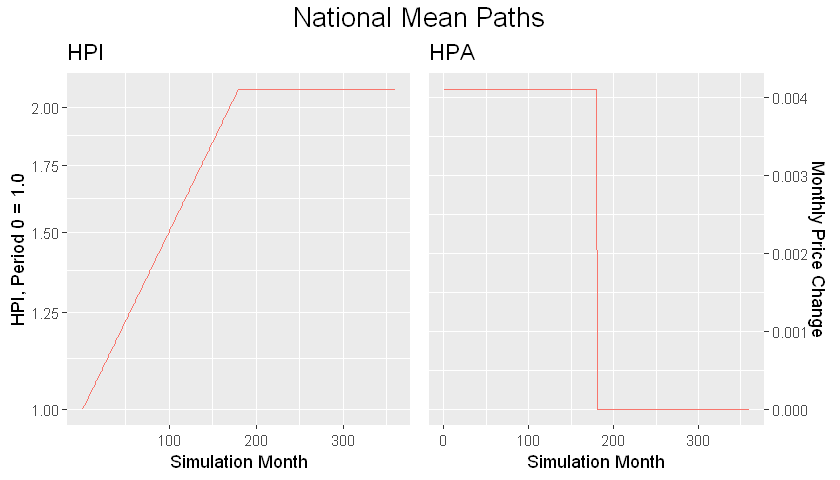

In [13]:
library(grid)
library(gridExtra)

# Plot national mean HPA and HPI paths
state <- "00"

path.df <- data.frame(period=1:num.months,
                      mean.hpa.path=mean.hpa.path[state,],
                      mean.hpi.path=mean.hpi.path[state,])

options(repr.plot.height=4)
plot1 <- ggplot(path.df, aes(x = period)) +
            geom_line(aes(y=mean.hpi.path, colour="Mean HPI Path")) +
            ggtitle("HPI") +
            coord_trans(y = "log") +
            xlab("Simulation Month") +
            ylab("HPI, Period 0 = 1.0") +
            theme(legend.position="none")
plot2 <- ggplot(path.df, aes(x = period)) +
            geom_line(aes(y=mean.hpa.path, colour="Mean HPA Path")) +
            ggtitle("HPA") +
            scale_y_continuous(position = "right") +
            xlab("Simulation Month") +
            ylab("Monthly Price Change") +
            theme(legend.position="none")
grid.arrange(plot1, plot2, ncol=2, 
             top = textGrob("National Mean Paths",gp=gpar(fontsize=16)))

In [14]:
write.csv(mean.hpa.path, file="mean.hpa.path.csv")

In [15]:
# Create array for storing HPI simulation results
    # Dimension 1: states
    # Dimension 2: simulation
    # Dimension 3: month
hpi.array <- array(NA, dim=c(nrow(initial.hpi), num.sims, num.months))
dimnames(hpi.array) <- list(market=rownames(initial.hpi),
                            sim=c(1:dim(hpi.array)[2]),
                            period=c(1:dim(hpi.array)[3]))


# Run simulations
for (k in 1:num.sims) {
  
  hpi.array[,k,] <- exp(simulate.mod.multi.chol(num.months, mean.hpa.path, 
                                                initial.hpi, log(mean.hpi.path), 
                                                sim.mod.coef, chol.mat))
  
}

r_multi <- summ.by.sim(hpi.array)


cat("\n")
cat("Annual Mean Returns:\n")
ret.mean <- aggregate((ret.mean*12)~market, data=r_multi, mean)
ret.mean[,2] <- format(ret.mean[,2], digits=5)
ret.mean[,3] <- format((mean.hpa/2)*12, digits=5)
colnames(ret.mean) <- c('state','ret.mean','target')
ret.mean$state <- states
print(ret.mean, row.names=FALSE)

cat("\n")
cat("Annual Return Standard Deviations:\n")
sd.mean <- aggregate((ret.sd*sqrt(12))~market, data=r_multi, mean)
sd.mean[,2] <- format(sd.mean[,2], digits=5)
sd.mean[,3] <- format(hist.values$avg.vol[order(rownames(hist.values))], digits=5)
colnames(sd.mean) <- c('state','sd.mean','target')
sd.mean$state <- states
print(sd.mean, row.names=FALSE)

cat("\n")
cat("Target Residual Correlations:\n")
rho.df <- data.frame(cor.mat,
                     row.names=rownames(cor.mat))
colnames(rho.df) <- colnames(cor.mat)
print(format(rho.df, digits=3))

cat("\n")
cat("Simulated Residual Correlations:\n")
cor.mat <- hpa_dev.cor(hpi.array, mean.hpa)
print(format(cor.mat, digits=3))



Annual Mean Returns:
 state ret.mean   target
    00 0.024671 0.024649
    01 0.016740 0.016689
    04 0.022237 0.022239
    06 0.031515 0.031407

Annual Return Standard Deviations:
 state  sd.mean   target
    00 0.021822 0.020723
    01 0.021281 0.020793
    04 0.029120 0.029242
    06 0.029073 0.030696

Target Residual Correlations:
       00     01     04    06
00 1.0000 0.0677 0.0983 0.139
01 0.0677 1.0000 0.1078 0.214
04 0.0983 0.1078 1.0000 0.235
06 0.1392 0.2138 0.2351 1.000

Simulated Residual Correlations:
      00    01    04    06
00 1.000 0.137 0.164 0.229
01 0.137 1.000 0.150 0.265
04 0.164 0.150 1.000 0.291
06 0.229 0.265 0.291 1.000


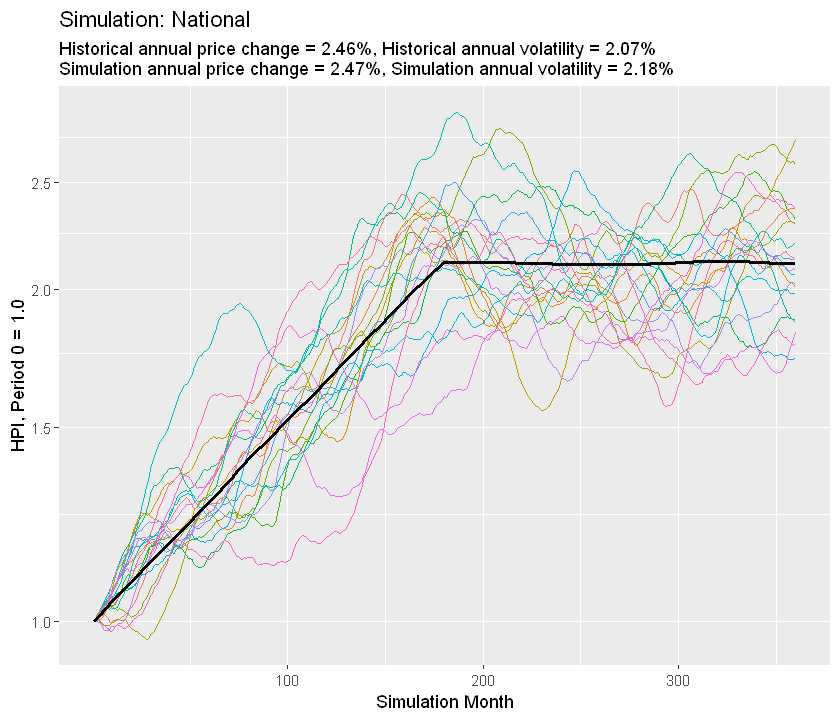

In [16]:
state <- "00"

hpi.array.us <- hpi.array[state,,]

hpi.paths <- as.data.frame(as.table(hpi.array.us))
hpi.paths$period <- as.integer(hpi.paths$period)
colnames(hpi.paths)[3] <- "value"

options(repr.plot.height=6)
print(ggplot(hpi.paths, aes(period, value)) + 
        geom_line(aes(colour = sim), 
                  data=function(x){x[x$sim %in% as.character(1:20), ]}) +
        stat_summary(aes(y = value), fun.y=mean, colour="black", 
                     geom="line", size=1) +
        coord_trans(y = "log") +
        theme(legend.position="none") +
        ggtitle(paste("Simulation: National"),
                subtitle=(paste0("Historical annual price change = ",
                                 percent(as.numeric(mean.hpa[state,]/2)*12),
                                 ", Historical annual volatility = ",
                                 percent(hist.values[state,'avg.vol']),
                                 "\n",
                                 "Simulation annual price change = ",
                                 percent(as.numeric(ret.mean[ret.mean$state==state,"ret.mean"])), 
                                 ", Simulation annual volatility = ",
                                 percent(as.numeric(sd.mean[sd.mean$state==state,"sd.mean"]))))) +
        xlab("Simulation Month") +
        ylab("HPI, Period 0 = 1.0"))

## (3) Model Deployment

### (3.1) Model Coefficient Files

Three sets of model coefficients should be loaded into the RiskModel to control the simulations generated by the HPI simulator. The first set contains the estimated mean reversion and momentum parameters ($ \hat{\alpha}_i $ and $ \hat{\beta}_i $) for the U.S. and states (`lm.mod.coef.states.csv`) and CBSAs (`lm.mod.coef.cbsas.csv`). The second set contains the Cholesky decompositions of the cross-market HPA correlations ($ C_{ij} $) for the U.S. and states (`chol.state.csv`) and CBSAs (`chol.cbsa.csv`). The last set contains parameters for controlling property-level HPI simulations.

(Note: The mean reversion and momentum parameters will be re-estimated so that they are consistent with seasonal adjustment procedure outlined in section (1.2). The property-level model parameters must also be re-estimated for the markets covered by the 4.4 version of the HPI simulator and newly estimated for states and CBSAs added to the coverage of the 5.0 version of the model.)